<a href="https://colab.research.google.com/github/naznmr/Sepsis/blob/main/sepsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import pickle
import math
import missingno as msno
from multiprocessing.dummy import Pool as ThreadPool
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func
import sklearn.metrics as metrics
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy.interpolate import interp1d
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import requests
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
import ssl
import urllib.request

# تنظیم SSL context برای غیرفعال کردن چک کردن گواهی
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# download data
import os
import urllib.request
urllib.request.urlretrieve('https://archive.physionet.org/users/shared/challenge-2019/training_setA.zip','training_setA.zip')
# unzip
!unzip -q training_setA.zip
# delete zip file
!rm training_setA.zip
!mv training training_setA

In [ ]:
data_path = "training_setA"
patient_ids = sorted(os.listdir(data_path))
data = [] # list of df for each patient

for i in tqdm(range(len(patient_ids))):
    # read in patient data
    df = pd.read_csv(data_path + '/' + patient_ids[i], sep = "|")
    df['PatientID'] = patient_ids[i]
    data.append(df)

100%|██████████| 20336/20336 [01:04<00:00, 314.30it/s]


1 - 1 تحلیل داده های اکتشافی

1 - چه درصد از بیماران به سپسیس مبتلا هستند؟

In [ ]:
sepsis = "SepsisLabel"
sepsis_count = 0
total_records = 0

for i in data:
    if sepsis in i.columns:
        sepsis_count += i[sepsis].sum()
        total_records += len(i)

if total_records > 0:
  sepsis_percent = (sepsis_count / total_records) * 100
else:
  sepsis_percent = 0

print("percent of sepsis patient = ", sepsis_percent)

percent of sepsis patient =  2.168523756192935


2 - توزیع جنسیت بیماران چگونه است؟ همچنین، میانگین و میانه سن بیماران چقدر است؟

In [ ]:
gender = "Gender"
male_count = 0
female_count = 0

for i in data:
  male_sum = (i[gender] == 0).sum()
  female_sum = (i[gender] == 1).sum()
  male_count += male_sum
  female_count += female_sum

print("Female count = ", female_count)
print("Male count = ", male_count)

age = "Age"
combined_data = pd.concat(data, ignore_index=True)

mean_age = combined_data[age].mean()
median_age = combined_data[age].median()

print("mean = ", mean_age)
print("median = ", median_age)

Female count =  456524
Male count =  333691
mean =  63.01677985105323
median =  65.25


3 - یک هیستوگرام از طول مدت داده های بیماران رسم کنید.

length of patients = 
 [54, 23, 48, 29, 48, 17, 45, 40, 258, 23, 34, 21, 39, 42, 15, 19, 37, 134, 48, 19, 57, 19, 21, 51, 50, 13, 10, 31, 48, 45, 55, 51, 37, 13, 41, 16, 18, 38, 45, 24, 34, 73, 45, 34, 19, 50, 18, 16, 18, 50, 40, 43, 25, 57, 14, 9, 35, 8, 37, 9, 18, 41, 14, 28, 29, 19, 18, 46, 12, 36, 54, 20, 23, 13, 38, 50, 23, 104, 42, 37, 36, 44, 50, 42, 55, 20, 46, 15, 26, 41, 54, 32, 29, 37, 35, 19, 34, 54, 22, 38, 36, 46, 19, 41, 37, 59, 40, 48, 48, 40, 49, 37, 21, 29, 56, 22, 48, 19, 17, 40, 45, 39, 49, 24, 41, 10, 49, 23, 26, 48, 46, 56, 56, 38, 17, 30, 40, 38, 42, 29, 61, 49, 53, 51, 26, 22, 44, 58, 25, 23, 24, 42, 22, 29, 34, 36, 42, 40, 37, 53, 23, 53, 35, 44, 39, 29, 19, 30, 53, 52, 69, 22, 24, 24, 20, 28, 24, 97, 50, 40, 24, 43, 36, 39, 65, 47, 44, 84, 57, 53, 37, 31, 40, 19, 31, 20, 42, 16, 37, 43, 47, 58, 81, 20, 41, 23, 59, 20, 44, 19, 8, 43, 55, 38, 38, 40, 35, 45, 48, 54, 54, 47, 43, 39, 40, 18, 37, 53, 27, 54, 34, 22, 22, 25, 38, 24, 31, 19, 19, 23, 20, 40, 46, 26, 5

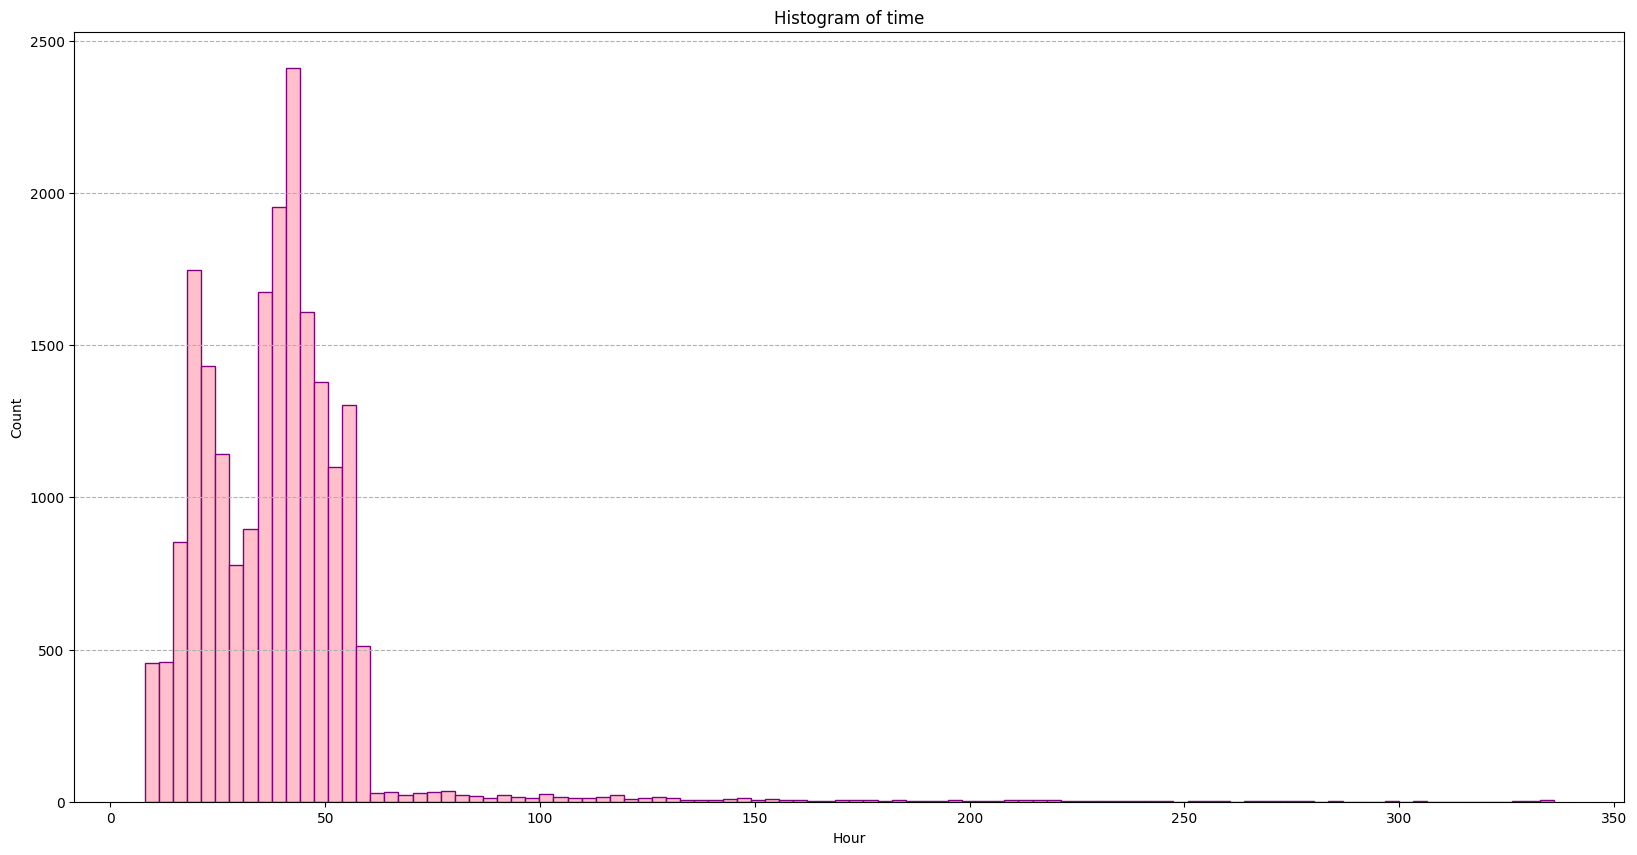

In [ ]:
patient_length = []

for i in data:
  len_i = len(i)
  patient_length.append(len_i)

print("length of patients = \n", patient_length)
print("\n")

plt.figure(figsize = (20, 10))
plt.hist(patient_length, bins = 100, color = "pink", edgecolor = "purple")
plt.title("Histogram of time")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.grid(axis = "y", linestyle = "--")
plt.show()

4 - یک هیستوگرام از اولین ساعتی که بیماران به سپسیس مبتلا می شوند را رسم کنید.

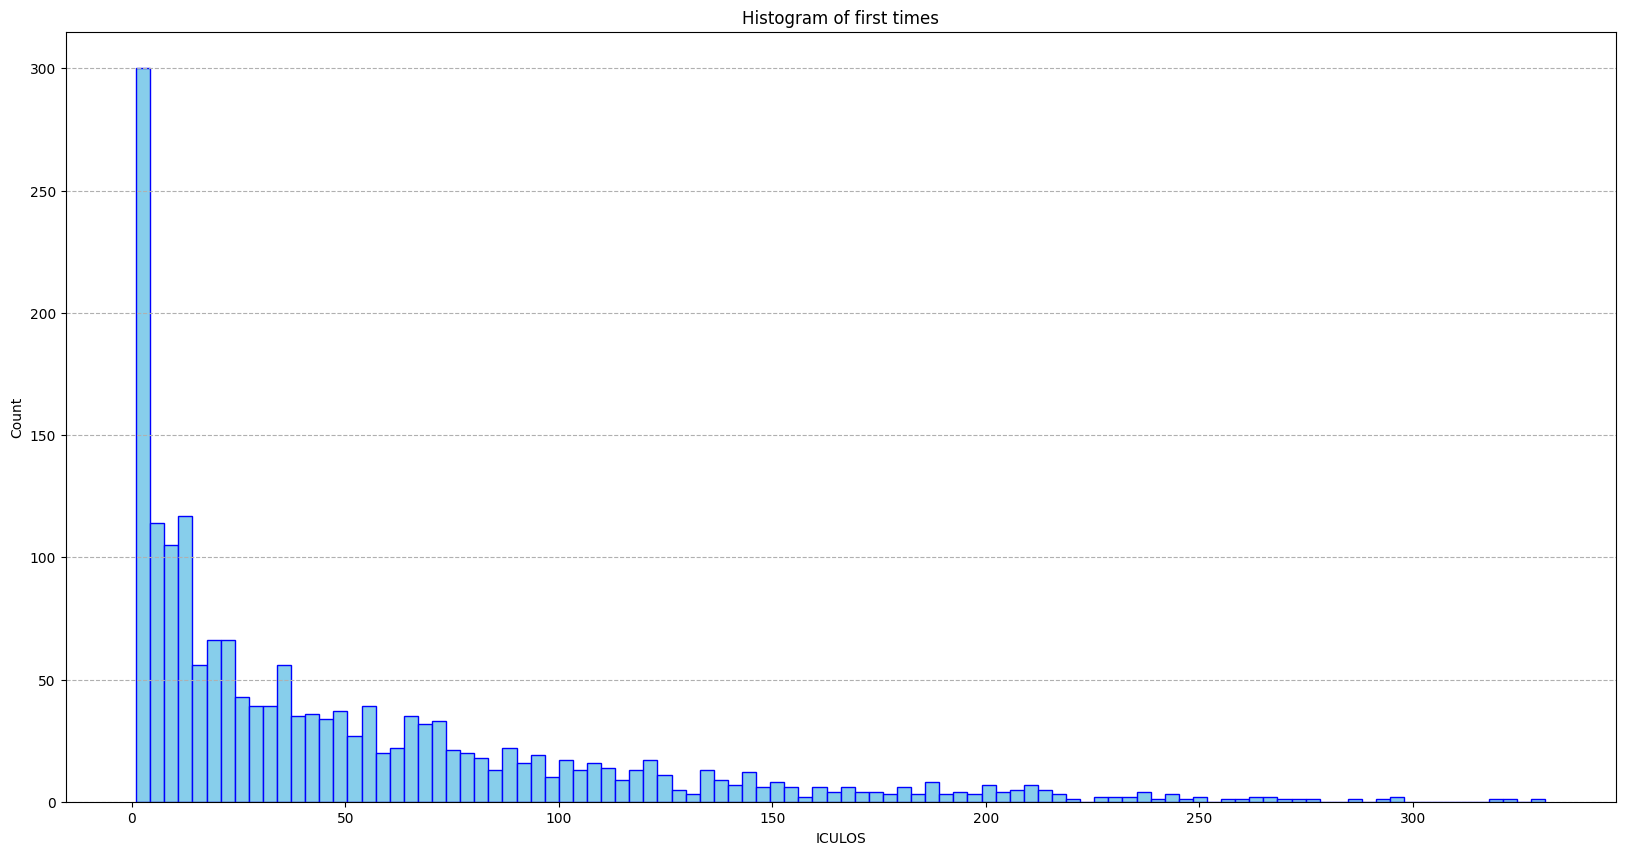

In [ ]:
sepsis = "SepsisLabel"
sepsis_time = "ICULOS"
sepsis_times = []

for i in data:
    if (sepsis in i.columns) and (sepsis_time in i.columns):
        sepsis_rows = i[i[sepsis] == 1]
        if not sepsis_rows.empty:
            sepsis_times.append(sepsis_rows[sepsis_time].iloc[0])


plt.figure(figsize = (20, 10))
plt.hist(sepsis_times, bins = 100, color = "skyblue", edgecolor = "blue")
plt.title("Histogram of first times")
plt.xlabel("ICULOS")
plt.ylabel("Count")
plt.grid(axis = "y", linestyle = "--")
plt.show()

5 - یک هیستوگرام از میزان فقدان داده ها برای هر ویژگی در بین تمام بیماران رسم کنید

Top 5 missing data : 

EtCO2: 1.0
TroponinI: 0.9987788133609208
Bilirubin_direct: 0.9985042045519258
Fibrinogen: 0.9923691653537329
Bilirubin_total: 0.9877337180387616


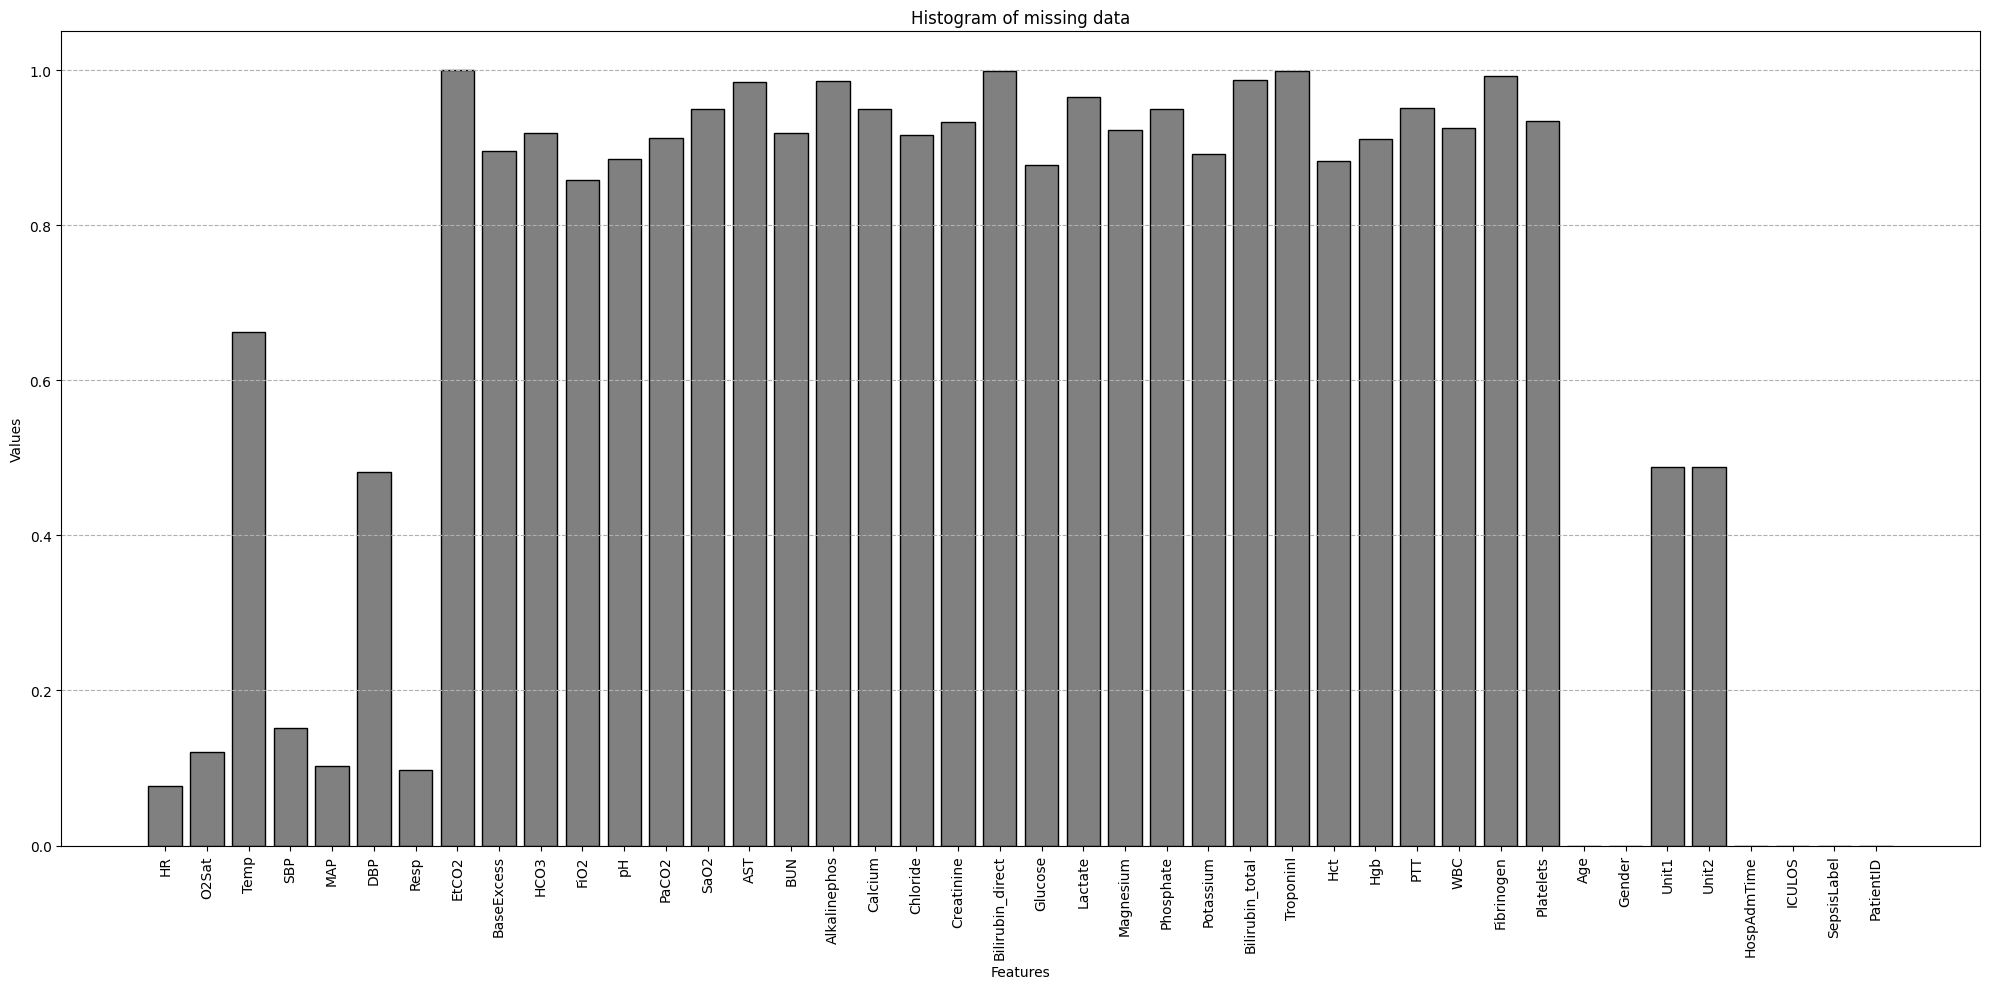

In [ ]:
missing_data = {}
total_rows = 0

for i in data:
    total_rows += len(i)
    for k in i.columns:
        if k not in missing_data:
            missing_data[k] = 0
        missing_data[k] += i[k].isna().sum()

missing = {}

for j in missing_data:
    cal = missing_data[j] / total_rows
    missing[j] = cal

sorted_missing = sorted(missing.items(), key=lambda x: x[1], reverse = True)

top_5_missing = sorted_missing[:5]

print("Top 5 missing data : \n")

for m, n in top_5_missing:
    print(f"{m}: {n}")

features = list(missing.keys())
values = list(missing.values())

plt.figure(figsize = (20, 10))
plt.bar(features, values, color = "gray", edgecolor = "black")
plt.title("Histogram of missing data")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation = 90)
plt.grid(axis = "y", linestyle = "--")
plt.tight_layout()
plt.show()

1 - 2 یادگیری مدل برای پیشبینی سپسیس

تکمیل مقادیر گمشده

In [ ]:
combined_data = pd.concat(data, ignore_index = True)

missing_data = combined_data.isna().mean()
missing_percent = missing_data * 100

print("Percent of missing data : \n")
print(missing_percent)
print("\n")

missing_threshold = 50
features_to_drop = missing_percent[missing_percent > missing_threshold].index

print("Droped Features : ", len(features_to_drop), " Features will drop. \n")
print(features_to_drop.tolist())

X = combined_data.drop(columns = features_to_drop)

numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = X.select_dtypes(exclude=['float64', 'int64']).columns

X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].mean())

print("All datas : \n")
print(X)